****
# Auto-Machine Learning Model Selection using GridSearchCV
****
<p style="text-align: right"><i>Jesus Perez Colino<br>First version: November 2018<br></i></p>

## About this notebook: 
****
Notebook prepared by **Jesus Perez Colino** Version 0.2, First Released: 25/11/2018, Alpha

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


- **Summary**: 

>This notebook aim to give a simple example of how to build an automatic machine learning system to quickly build, assess and test locally (using multiporcessing in Scikit-learn) several hundreds of Machine Leaning models versions for predictions. Model selection by 'brut force'.

- **Index**: 
    1. Feature engineering using pipelines with pandas
    2. Automatic Machine Learning Model estimation using GridSearchCV
    3. Results

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

import watermark
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [4]:
%load_ext watermark
print(' Reproducibility conditions for this notebook '.center(85,'-'))
%watermark -n -v -m -p numpy,scipy,matplotlib,pandas,sklearn
print('-'*85)

-------------------- Reproducibility conditions for this notebook -------------------
Sun Jan 12 2020 

CPython 3.6.8
IPython 7.10.1

numpy 1.17.4
scipy 1.3.1
matplotlib 3.1.1
pandas 0.25.3
sklearn 0.21.3

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
-------------------------------------------------------------------------------------


# 1. Feature engineering using pipelines in pandas

In [5]:
file_path_train = r"C:\Users\admin\Documents\Exercise_train.csv"
file_path_test = r"C:\Users\admin\Documents\Exercise_test.csv"

training_df = pd.read_csv(file_path_train)
testing_df = pd.read_csv(file_path_test)

In [6]:
# Decorator to log the time of data transformations

def timelog(f):
    def wrapper(dataf, *args, **kargs):
        tic = dt.datetime.now()
        result =f(dataf, *args, **kargs)
        toc = dt.datetime.now()
        print(f"{f.__name__} took {toc - tic} with shape = {result.shape}" )
        return result
    return wrapper  

In [7]:
@timelog
def start_pipeline(raw_df):
    return raw_df.copy()

@timelog
def clean_data(raw_df):
    name_columns = ['X{}'.format(i) for i in range(len(raw_df.columns)-1)]
    name_columns.append('poor')
    df = pd.DataFrame(raw_df.values,
                  index = raw_df.id, 
                  columns = name_columns)
    df_clean = df.iloc[:, 2:].dropna()
    return df_clean

@timelog
def type_data(df_clean):
    types_dict = {'X2':str, 'X3':str, 'X4':str, 'X5':str, 
                  'X6':np.float64, 'X7':np.float64, 'X8':np.float64, 'X9':np.float64, 
                  'poor':bool}
    for col, col_type in types_dict.items():
        df_clean[col] = df_clean[col].astype(col_type)
    return df_clean
    

@timelog
def one_hot_encoder(df):
    X_string = df.select_dtypes(exclude = ['float64', bool])
    for column_to_encode in X_string.columns:
        X_string = pd.concat([X_string, pd.get_dummies(X_string[column_to_encode])],axis=1)

    X_string = X_string.drop(X_string.select_dtypes(include = object), axis = 1)
    X_1hot= pd.concat([X_string, df.iloc[:,:-1].select_dtypes(include='float64')], axis = 1)
    return X_1hot

@timelog
def std_scaler(df):
    sc =StandardScaler()
    df_sc = pd.DataFrame(sc.fit_transform(df.select_dtypes(include = ['float64'])),
                         columns=df.select_dtypes(include = ['float64']).columns)
    df[df.select_dtypes(include = ['float64']).columns]=df_sc.values
    return df

@timelog
def min_max_scaler(df):
    mm = MinMaxScaler()
    df_mm = pd.DataFrame(mm.fit_transform(df.select_dtypes(include = ['float64'])),
                         columns=df.select_dtypes(include = ['float64']).columns)
    df[df.select_dtypes(include = ['float64']).columns]=df_mm.values
    return df

@timelog
def get_target(df):
    y = df.iloc[:,-1]
    y, y_categ = y.factorize()
    return y


In [8]:
X_training_df = (training_df
                 .pipe(start_pipeline)
                 .pipe(clean_data)
                 .pipe(type_data)
                 .pipe(one_hot_encoder)
                 .pipe(std_scaler))

start_pipeline took 0:00:00.000961 with shape = (6562, 11)
clean_data took 0:00:00.012966 with shape = (5132, 9)
type_data took 0:00:00.008969 with shape = (5132, 9)
one_hot_encoder took 0:00:00.036935 with shape = (5132, 54)
std_scaler took 0:00:00.035869 with shape = (5132, 54)


In [9]:
X_testing_df = (testing_df
                 .pipe(start_pipeline)
                 .pipe(clean_data)
                 .pipe(type_data)
                 .pipe(one_hot_encoder)
                 .pipe(std_scaler))

start_pipeline took 0:00:00 with shape = (1641, 11)
clean_data took 0:00:00.005982 with shape = (1295, 9)
type_data took 0:00:00.005990 with shape = (1295, 9)
one_hot_encoder took 0:00:00.032910 with shape = (1295, 54)
std_scaler took 0:00:00.037936 with shape = (1295, 54)


In [10]:
Y_training_df = (training_df
                 .pipe(start_pipeline)
                 .pipe(clean_data)
                 .pipe(type_data)
                 .pipe(get_target))

start_pipeline took 0:00:00.000974 with shape = (6562, 11)
clean_data took 0:00:00.016956 with shape = (5132, 9)
type_data took 0:00:00.008959 with shape = (5132, 9)
get_target took 0:00:00 with shape = (5132,)


In [11]:
Y_testing_df = (testing_df
                 .pipe(start_pipeline)
                 .pipe(clean_data)
                 .pipe(type_data)
                 .pipe(get_target))

start_pipeline took 0:00:00 with shape = (1641, 11)
clean_data took 0:00:00.005987 with shape = (1295, 9)
type_data took 0:00:00.003988 with shape = (1295, 9)
get_target took 0:00:00 with shape = (1295,)


# 2. Automatic Machine Learning Model estimation using GridSearchCV

In [12]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some models are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        
    def fit(self, X, y, cv=5, n_jobs=-1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [13]:
models1 = {
    'LogisticRegression': LogisticRegression(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'SVC': SVC()
}

In [14]:
params1 = {
    'LogisticRegression': {'penalty': ['l1','l2'], 
                           'C': np.linspace(1, 20, 5), 
                           'random_state': [123]},
    'GradientBoostingClassifier': {'n_estimators': np.linspace(1,500,5,dtype=int), 
                                'learning_rate':  np.linspace(0.0001,1,5), 
                                'max_depth' : [1,2,3], 
                                'random_state': [123]},
    'AdaBoostClassifier': {#'base_estimator' : ['DecisionTreeClassifier()'], 
                           'n_estimators' : np.linspace(40,100,5,dtype=int),
                           'algorithm' : ["SAMME.R"], 
                           'learning_rate' : np.linspace(0.0001,50,5), 
                           'random_state':[123]},
    'SVC': {'kernel': ['rbf', 'linear'], 
            'gamma':np.linspace(4,8,5,dtype=int),
            'C': np.linspace(0.001, 10, 5), 
            'random_state': [123]}
}

In [13]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_training_df, Y_training_df, scoring='f1', n_jobs=-1)

Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.7s finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  1.5min finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   10.5s finished


Running GridSearchCV for SVC.
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.7min finished


# 3. Results

In [14]:
helper1.score_summary(sort_by='max_score')

,estimator,min_score,mean_score,max_score,std_score,C,algorithm,gamma,kernel,learning_rate,max_depth,n_estimators,penalty,random_state
26,GradientBoostingClassifier,0.776699,0.782906,0.802817,0.0100112,NaN,NaN,NaN,NaN,0.250075,1,125,NaN,123
71,GradientBoostingClassifier,0.772365,0.782459,0.797178,0.00833114,NaN,NaN,NaN,NaN,1,1,125,NaN,123
28,GradientBoostingClassifier,0.772767,0.781844,0.796117,0.00769647,NaN,NaN,NaN,NaN,0.250075,1,375,NaN,123
56,GradientBoostingClassifier,0.77551,0.781293,0.795053,0.00712458,NaN,NaN,NaN,NaN,0.750025,1,125,NaN,123
0,LogisticRegression,0.762075,0.777293,0.794401,0.0109725,1,NaN,NaN,NaN,NaN,NaN,NaN,l1,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,AdaBoostClassifier,0.408881,0.471762,0.497985,0.0322126,NaN,SAMME.R,NaN,NaN,37.5,NaN,40,NaN,123
101,AdaBoostClassifier,0.408881,0.471762,0.497985,0.0322126,NaN,SAMME.R,NaN,NaN,37.5,NaN,55,NaN,123
103,AdaBoostClassifier,0.408881,0.471762,0.497985,0.0322126,NaN,SAMME.R,NaN,NaN,37.5,NaN,85,NaN,123
104,AdaBoostClassifier,0.408881,0.471762,0.497985,0.0322126,NaN,SAMME.R,NaN,NaN,37.5,NaN,100,NaN,123


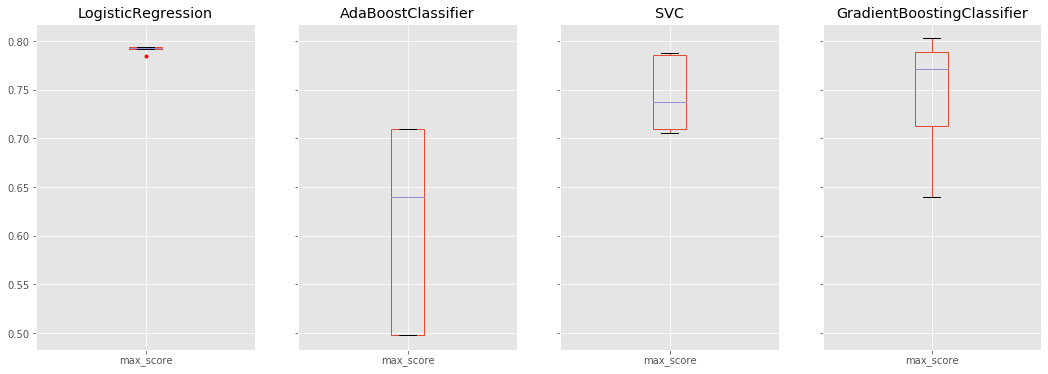

In [18]:

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(1,4, sharey=True, figsize=[18,6])
    for i,model in enumerate(set(helper1.score_summary()['estimator'])):
        df_max_score = helper1.score_summary()[helper1.score_summary()['estimator'] == model]['max_score']        
        df_max_score.plot.box(ax=ax[i], sym='r.', title=model)
        
        

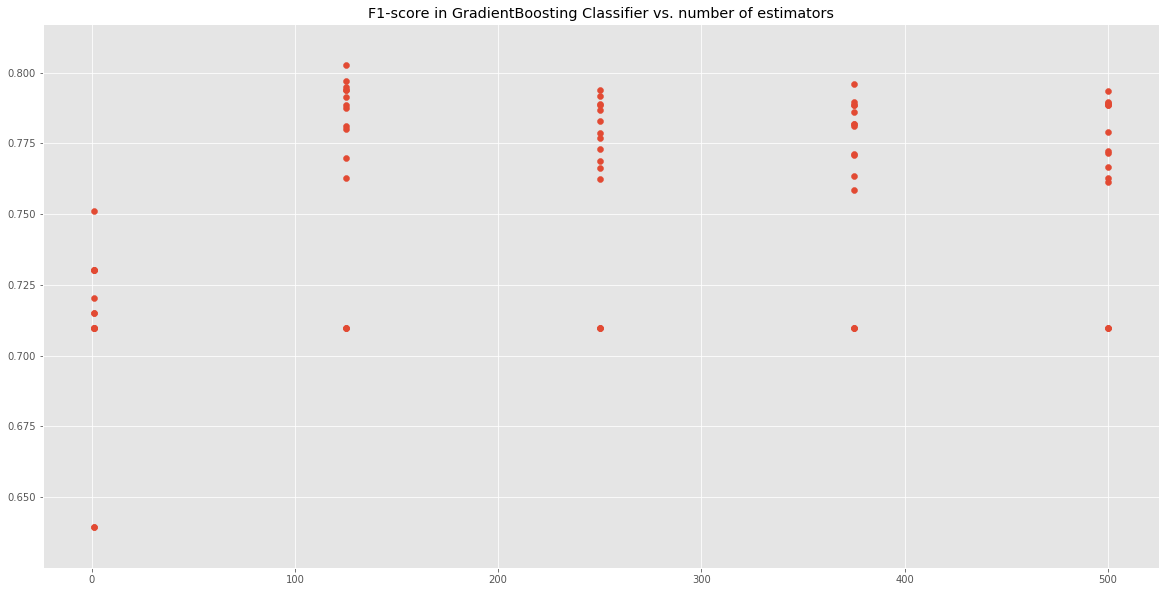

In [20]:
with plt.style.context(('ggplot')):
    y = helper1.score_summary()[helper1.score_summary()['estimator']=='GradientBoostingClassifier']['max_score']
    x = helper1.score_summary()[helper1.score_summary()['estimator']=='GradientBoostingClassifier']['n_estimators']
    plt.scatter(x,y)
    plt.title('F1-score in GradientBoosting Classifier vs. number of estimators')